In [53]:
from util import preprocess_image
from resnet18 import resnet18
import numpy as np
import torch
import torch.nn as nn
from dataset import Dataset_Generator, train_validation_test_split, get_classes_map, number_of_classes, number_of_channels, get_all_object_numbers_labels
from IPython.core.debugger import Tracer
import math

In [54]:
path_to_images = "data\\WBC\\test_samples_without_1_ch"
model_dict = "models\\final_model_dict_wth_ch1.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 2

In [55]:
only_channels = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#only_channels = []
only_classes = None
h5_file = "data/WBC/Lyse fix sample_1_Focused & Singlets & CD45 pos.h5"

In [56]:
num_classes = number_of_classes(h5_file, only_classes=only_classes)
num_channels = number_of_channels(h5_file, only_channels=only_channels)

In [88]:
model = resnet18(pretrained=True)
## loading the imagenet weights in case it is possible
if num_channels != 3:
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7), 
                            stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
model = model.to(device)
model.load_state_dict(torch.load(model_dict, map_location=torch.device(device)))

<All keys matched successfully>

In [89]:
from collections.abc import Sequence
from functools import partial
from typing import Optional, Union
from scipy.special import softmax
#softmax = nn.Softmax(dim=1)

try:
    from tqdm import trange

    trange = partial(trange, desc="Computing occlusion sensitivity")
except (ImportError, AttributeError):
    trange = range
    

def _append_to_sensitivity_im(model, batch_images, batch_ids, sensitivity_im):
    """For given number of images, get probability of predicting
    a given label. Append to previous evaluations."""
    batch_images = torch.cat(batch_images, dim=0)
    batch_ids = torch.LongTensor(batch_ids).unsqueeze(1).to(sensitivity_im.device)
    scores = model(batch_images).detach().gather(1, batch_ids)
    #Tracer()()
    return torch.cat((sensitivity_im, scores))

def compute_occlusion_sensitivity_debug_per_channel_custom(
    model: nn.Module,
    image: torch.Tensor,
    label: Union[int, torch.Tensor],
    pad_val: float = 0.0,
    margin: Union[int, Sequence] = 2,
    n_batch: int = 128,
    stride: Union[int, Sequence] = 1,
    upsample_mode: str = "nearest",
    threshold: float = 0.0,
    number_channels: int = 12,
) -> np.ndarray:

    im_shape = np.array(image.shape[1:])

    # Get baseline probability
    baseline = model(image).detach()[0, label].item()

    # Create some lists for batch processing 
    batch_images = []
    batch_ids = []

    sensitivity_im = torch.empty(0, dtype=torch.float32, device=image.device)
    
    # If no bounding box supplied, output shape is same as input shape.
    # If bounding box is present, shape is max - min + 1
    output_im_shape = im_shape

    # Calculate the downsampled shape
    if not isinstance(stride, Sequence):
        stride_np = np.full_like(im_shape, stride, dtype=np.int32)
        stride_np[0] = 1  # always do stride 1 in channel dimension
    else:
        # Convert to numpy array and check dimensions match
        stride_np = np.array(stride, dtype=np.int32)
        if stride_np.size != im_shape.size:
            raise ValueError("Sizes of image shape and stride should match.")

    # Obviously if stride = 1, downsampled_im_shape == output_im_shape
    downsampled_im_shape = np.floor(output_im_shape / stride_np).astype(np.int32)
    downsampled_im_shape[downsampled_im_shape == 0] = 1  # make sure dimension sizes are >= 1
    num_required_predictions = np.prod(downsampled_im_shape)
    
    for layer in range(number_channels):
        for i in trange(int(num_required_predictions / number_channels)):
            channel = image[0][layer].clone()
            stride_np = np.full_like(channel.shape, stride, dtype=np.int32)
            stride_np[0] = 1
            
            # Get corresponding ND index
            idx = np.unravel_index(i, downsampled_im_shape[1:])
    
            # Multiply by stride
            idx *= stride_np
                
            # Get min and max index of box to occlude
            min_idx = [max(0, i - margin) for i in idx]
            max_idx = [min(j, i + margin) for i, j in zip(idx, channel.shape)]
            #Tracer()()

            # Clone and replace target area with `pad_val`
            occlu_im = image.clone()
            channel[min_idx[0]:max_idx[0],min_idx[1]:max_idx[1]] = pad_val
            #channel[(...,) + tuple(slice(i, j) for i, j in zip(min_idx, max_idx))] = pad_val
            occlu_im[0][layer] = channel
            #plt.imshow(occlu_im[0].T)
            #Tracer()()

            # Add occluded images to list
            batch_images.append(occlu_im)
            batch_ids.append(label)
            if len(batch_images) == n_batch or i == int(num_required_predictions / number_channels) - 1:
            # Do the predictions and append to sensitivity map
                sensitivity_im = _append_to_sensitivity_im(model, batch_images, batch_ids, sensitivity_im)
                # Clear lists
                #Tracer()()
                batch_images = []
                batch_ids = []
    #Tracer()()
    # Subtract from baseline
    sensitivity_im = baseline - sensitivity_im

    # Reshape to match downsampled image
    sensitivity_im = np.where(sensitivity_im.cpu()<threshold, 0, sensitivity_im.cpu())
    #Tracer()()
    sensitivity_im = sensitivity_im.reshape(tuple(downsampled_im_shape))

    # If necessary, upsample
    if np.any(stride_np != 1):
        output_im_shape = tuple(output_im_shape[1:])  # needs to be given as 3D tuple
        upsampler = nn.Upsample(size=output_im_shape, mode=upsample_mode)
        sensitivity_im = upsampler(sensitivity_im.unsqueeze(0))

    # Convert tensor to numpy
    #sensitivity_im = sensitivity_im.cpu().numpy()
    #sensitivity_im = (sensitivity_im - np.min(sensitivity_im)) / (np.max(sensitivity_im) - np.min(sensitivity_im))
    #Tracer()()
    # Squeeze and return
    return np.squeeze(sensitivity_im)

In [93]:
import matplotlib.pyplot as plt
from pylab import *
def plot_heatmap(heatmap, number_channels):
    #fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(15,15))
    #fig, ax = plt.subplots(math.ceil(number_channels / 3), 3, figsize=(15,15))
    number_of_subplots = math.ceil(number_channels / 3)
    for i in range(number_channels):
        i = i + 1
        ax1 = subplot(number_of_subplots,3,i)
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
        ax1.imshow(heatmap[i-1])
    plt.show()

In [94]:
files_to_interpret, data_loader = preprocess_image(path_to_images, batch=2, num_workers=0)

Computing occlusion sensitivity: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:01<00:00, 4016.46it/s]


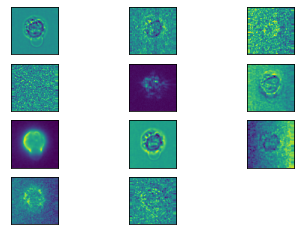

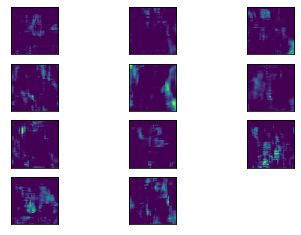

<ipython-input-101-5f11c61a79a8>:7: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  Tracer()()


> <ipython-input-101-5f11c61a79a8>(3)<module>()
      1 for test_data in data_loader:
      2     inputs, labels = test_data[0].to(device).float(), test_data[1].to(device)
----> 3     for (i,l) in zip(inputs, labels):
      4         occl = compute_occlusion_sensitivity_debug_per_channel_custom(model,i.reshape((1,num_channels,64,64)).float(),l,number_channels=num_channels, margin=16)
      5         plot_heatmap(i.cpu(), num_channels)



ipdb>  q


Exiting Debugger.


In [101]:
for test_data in data_loader:
    inputs, labels = test_data[0].to(device).float(), test_data[1].to(device)
    for (i,l) in zip(inputs, labels):
        occl = compute_occlusion_sensitivity_debug_per_channel_custom(model,i.reshape((1,num_channels,64,64)).float(),l,number_channels=num_channels, margin=16)
        plot_heatmap(i.cpu(), num_channels)
        plot_heatmap(occl, num_channels)
        Tracer()()